# Analys av Hälsostudie

**Syfte:** Denna anteckningsbok utför en statistisk analys av en hälsodata. Målet är att utforska sambanden mellan livsstilsfaktorer (ålder, vikt, rökstatus) och hälsometriker (blodtryck, kolesterol).

**Viktiga steg:**

**1. Deskriptiv analys:** Beräkning av sammanfattande statistik och visualisering av fördelningar.

**2. Simulering:** Jämförelse av sjukdomsprevalens mot en simulerad population.

**3. Konfidensintervall:** Beräkning av konfidensintervall och testning av hypoteser gällande rökning och blodtryck.

In [1]:
from src.io_utils import load_data
from src.health_analyzer import HealthAnalyzer

# 1. Load Data
df = load_data("data/health_study_dataset.csv")

# 2. Initialize Class (Put the data in the machine)
analyzer = HealthAnalyzer(df)

# 3. Test Methods (Press the buttons)
print("Stats:\n", analyzer.get_descriptive_stats())
real_prob, sim_prob = analyzer.run_disease_simulation()
print(f"\nSimulation: Real={real_prob:.2%}, Simulated={sim_prob:.2%}")

# --- Confidence Interval (Format with 2 decimals) ---
lower, upper = analyzer.calculate_bp_confidence_interval()
print(f"\nConfidence Interval: [{lower:.2f}, {upper:.2f}]")

# --- Hypothesis Test (Format with 4 decimals) ---
t_stat, p_val = analyzer.test_smoker_blood_pressure()
print(f"\nHypothesis Test: T-stat={t_stat:.4f}, P-value={p_val:.4f}")

Stats:
            age   weight     height  systolic_bp  cholesterol
mean  49.42625   73.413  171.84925   149.178625      4.92915
50%   50.00000   73.200  171.35000   149.400000      4.97000
min   18.00000   33.700  144.40000   106.800000      2.50000
max   90.00000  114.400  200.40000   185.900000      7.88000

Simulation: Real=5.88%, Simulated=5.60%

Confidence Interval: [148.29, 150.07]

Hypothesis Test: T-stat=0.4503, P-value=0.3264


## 1. Deskriptiv Analys

Här beräknar vi medel-, median-, min- och maxvärdena för de relevanta hälsometrikerna. Detta ger oss en första överblick över befolkningens fördelning.

In [2]:
from src.analysis import get_descriptive_stats

required_stats = get_descriptive_stats(df)

display(required_stats)

,age,weight,height,systolic_bp,cholesterol
mean,49.42625,73.413,171.84925,149.178625,4.92915
50%,50.00000,73.200,171.35000,149.400000,4.97000
min,18.00000,33.700,144.40000,106.800000,2.50000
max,90.00000,114.400,200.40000,185.900000,7.88000


**Observationer:**

Ålder: Deltagarna är mellan 18 och 90 år gamla, med en medelålder på cirka 49 år.

Blodtryck: Medelvärdet för systoliskt blodtryck ligger på 149, vilket är relativt högt.

Spridning: Vi ser en stor variation i vikt (33 kg till 114 kg), vilket tyder på en blandad population.

### Grafer

### Graf 1 - Histogram över blodtryck

Vi använder ett histogram för att visualisera hur blodtrycket är fördelat över populationen.

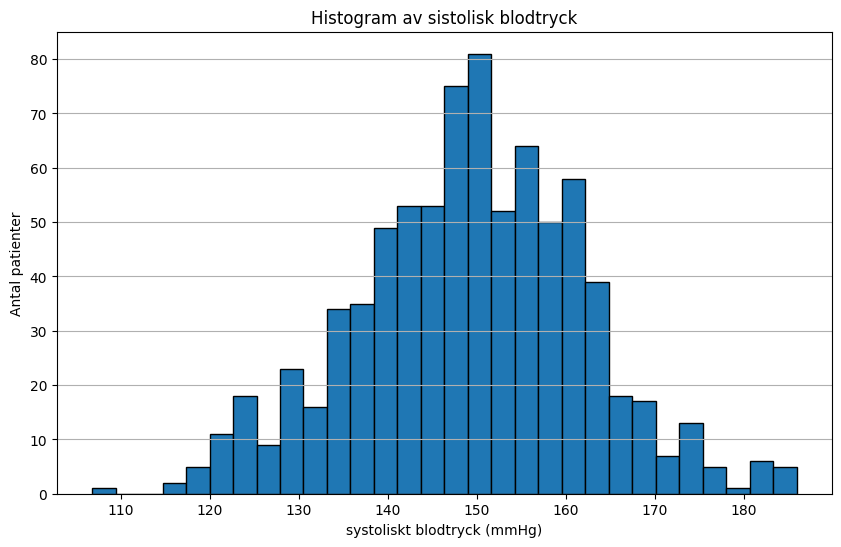

In [3]:
from src.viz import plot_bp_histogram

plot_bp_histogram(df)

In [4]:
total_patients = len(df)

high_bp_count = df[df['systolic_bp'] > 140].shape[0]

percentage_high_bp = (high_bp_count / total_patients) * 100

print(f"Total antal patienter: {total_patients}")
print(f"Antal patienter med högt blodtryck (> 140): {high_bp_count}")
print(f"Andel patienter med högt blodtryck: {percentage_high_bp:.2f}%")

Total antal patienter: 800
Antal patienter med högt blodtryck (> 140): 615
Andel patienter med högt blodtryck: 76.88%


**Observation:**

Analys av Histogrammet visar en ungefär normalfördelning, men den är centrerad kring 150 mmHg, vilket är ganska högt.

För att kvantifiera detta beräknar vi andelen patienter som överskrider tröskeln för högt blodtryck (hypertoni), vilket vanligtvis definieras som ett systoliskt tryck > 140 mmHg.

### Graf 2 - Boxplot över vikt per kön

<Figure size 800x600 with 0 Axes>

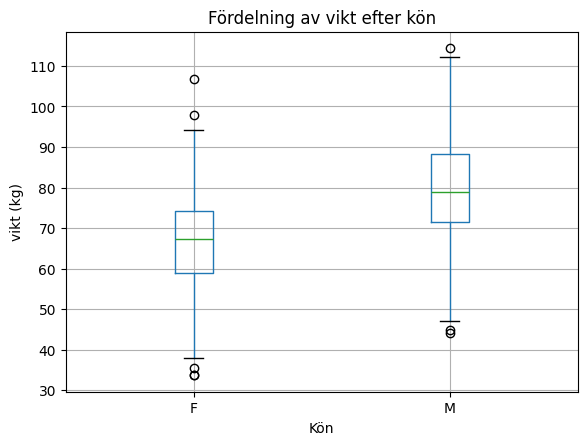

In [5]:
from src.viz import plot_weight_boxplot

plot_weight_boxplot(df)

**Observation:**

Medianvärde: Som väntat ligger medianvikten (den gröna linjen i mitten av boxen) högre för män (M) än för kvinnor (F).

Spridning: Båda grupperna visar en relativt symmetrisk fördelning (boxarna är jämna uppåt och nedåt).

Utliggare (Outliers): De små cirklarna utanför "morrhåren" (strecken) representerar individer med extremvärden. Vi ser att det finns personer med både mycket låg och mycket hög vikt i båda grupperna som avviker från mängden.

### Graf 3 - Stapel diagram över andelen rökare

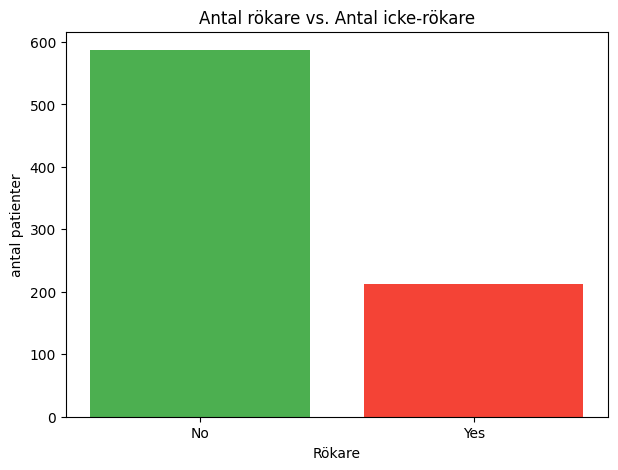

In [6]:
from src.viz import plot_smoker_bar_chart

plot_smoker_bar_chart(df)

**Observation:**

Fördelning: Grafen visar tydligt att rökare utgör en minoritet. Förhållandet är cirka 3:1 (ca 75% icke-rökare mot 25% rökare).

Metodologisk notering: Denna obalans i gruppstorlek (Class Imbalance) är viktig att notera inför vår hypotesprövning senare. Eftersom gruppen "Rökare" är betydligt mindre, kan det påverka säkerheten i våra statistiska tester, men stickprovet är sannolikt fortfarande tillräckligt stort för att dra slutsatser.

# 2. Simulering


Här beräknar vi först den faktiska andelen sjuka i datasetet. Därefter använder vi denna andel som sannolikhet för att simulera en grupp på 1000 personer. 

Den verkliga andelen sjuka i datasetet är 5.88%, medan vår simulering av 1000 personer resulterade i 5.60%. Skillnaden är mycket liten, vilket bekräftar att den slumpmässiga simuleringen väl representerar den underliggande sannolikheten.

In [7]:
from src.analysis import run_disease_simulation

real_prob, sim_prob = run_disease_simulation(df)


print(f"Verklig sjukdomsprocent i datasetet: {real_prob * 100:.2f}%")
print(f"Simulerad procentandel i 1000 personer: {sim_prob * 100:.2f}%")

Verklig sjukdomsprocent i datasetet: 5.88%
Simulerad procentandel i 1000 personer: 5.60%


# 3. Konfidensintervall och Hypotesprövning

## Konfidensintervall för medelvärdet av systolisk blodtryck

In [8]:
from src.analysis import calculate_confidence_interval

lower_ci, upper_ci = calculate_confidence_interval(df)

print(f"95% konfidensintervallet för medelvärdet av systoliskt blodtryck är: [{lower_ci:.2f}, {upper_ci:.2f}]")

95% konfidensintervallet för medelvärdet av systoliskt blodtryck är: [148.29, 150.07]


Baserat på våran data, vi beräknat 95% konfidensintervall för medelverdet av systoliskt blodtryck. Intervallet är [148.29, 150.07].

**Slutsats**: Baserat på vårt urval av 800 patienter är vi 95 % säkra på att det verkliga genomsnittliga systoliska blodtrycket för hela populationen (från vilken detta urval hämtades) ligger någonstans mellan 148,29 mmHg och 150,07 mmHg.

## Hypotesprövning

Hypotesen 'Rökare har högre medel-blodtryck än icke rökare' är testad. För att testa detta utförde vi ett t-test med två stickprov.

In [9]:
from src.analysis import test_smoker_blood_pressure

t_stat, p_value = test_smoker_blood_pressure(df)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-statistic: 0.4503
P-value: 0.6527


**Slutsats:** 

Testet resulterade i ett p-värde på 0,6527. Detta innebär att om det inte fanns någon skillnad i verkligheten, skulle det ändå vara 65% sannolikhet att få data som ser ut så här (eller mer extrem) av ren slump.

Eftersom 0,6527 är betydligt högre än vår gräns på 0,05, kan vi inte förkasta hypotesen (nollhypotesen). Vår analys visar alltså inga statistiska belägg för att rökare har högre blodtryck i detta dataset.

In [ ]:
# 2. Run the regression
coefs, intercept = analyzer.predict_blood_pressure()

# 3. Print the results
print(f"Intercept: {intercept:.2f}")
print(f"Age Coefficient: {coefs[0]:.2f}")
print(f"Weight Coefficient: {coefs[1]:.2f}")

Intercept: 109.50
Age Coefficient: 0.54
Weight Coefficient: 0.18


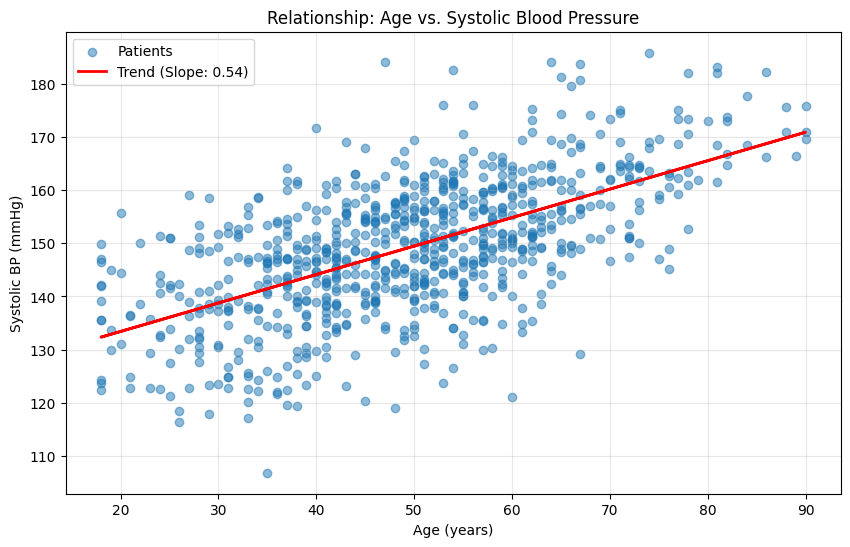

In [11]:
from src.viz import plot_age_vs_bp

# Run the visualization
plot_age_vs_bp(df)